In [11]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import ttest_ind

In [2]:
data_splits = ["complete"]
data_dict = load_data(data_splits)

In [3]:
cp_features = infer_cp_features(data_dict["complete"])
complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")

In [4]:
decoder_beta = keras.models.load_model("models/level5Decoder_beta")
decoder_vanilla = keras.models.load_model("models/level5Decoder_vanilla")
decoder_mmd = keras.models.load_model("models/level5Decoder_mmd")
encoder_beta = keras.models.load_model("models/level5Encoder_beta")
encoder_vanilla = keras.models.load_model("models/level5Encoder_vanilla")
encoder_mmd = keras.models.load_model("models/level5Encoder_mmd")

2022-01-11 21:09:04.657619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 21:09:04.657665: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 21:09:04.657700: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-3-81): /proc/driver/nvidia/version does not exist
2022-01-11 21:09:04.657968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
reconstruction_vanilla = decoder_vanilla.predict(encoder_vanilla.predict(complete_features_df)[0])
reconstruction_beta = decoder_beta.predict(encoder_beta.predict(complete_features_df)[0])
reconstruction_mmd = decoder_mmd.predict(encoder_mmd.predict(complete_features_df)[0])

2022-01-11 21:09:06.622650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
variance = complete_features_df.var()

In [7]:
difference_vanilla = pd.DataFrame(np.sum(np.abs(reconstruction_vanilla - complete_features_df)), columns = ['Vanilla VAE Reconstruction difference']).assign(Feature_Variance = variance)
difference_beta =  pd.DataFrame(np.sum(np.abs(reconstruction_beta - complete_features_df)), columns = ['Beta-VAE Reconstruction difference']).assign(Feature_Variance = variance)
difference_mmd =  pd.DataFrame(np.sum(np.abs(reconstruction_mmd - complete_features_df)), columns = ['MMD-VAE Reconstruction difference']).assign(Feature_Variance = variance)

In [8]:
difference_vanilla['compartment'] = difference_vanilla.index.str.split('_').str[0]
difference_beta['compartment'] = difference_beta.index.str.split('_').str[0]
difference_mmd['compartment'] = difference_mmd.index.str.split('_').str[0]


difference_vanilla['image_channel'] = difference_vanilla.index.str.split('_').str[3]
difference_beta['image_channel'] = difference_beta.index.str.split('_').str[3]
difference_mmd['image_channel'] = difference_mmd.index.str.split('_').str[3]

difference_vanilla['compartment - image_channel'] = difference_vanilla.index.str.split('_').str[0] + '-' + difference_vanilla.index.str.split('_').str[3]
difference_beta['compartment - image_channel'] = difference_beta.index.str.split('_').str[0] + '-' + difference_beta.index.str.split('_').str[3]
difference_mmd['compartment - image_channel'] = difference_mmd.index.str.split('_').str[0] + '-' + difference_mmd.index.str.split('_').str[3]


In [9]:
difference_vanilla = difference_vanilla[difference_vanilla['image_channel'].isin(['DNA','ER','Mito','RNA','AGP'])]
difference_beta = difference_beta[difference_beta['image_channel'].isin(['DNA','ER','Mito','RNA','AGP'])]
difference_mmd = difference_mmd[difference_mmd['image_channel'].isin(['DNA','ER','Mito','RNA','AGP'])]


In [18]:
print(ttest_ind(difference_vanilla[difference_vanilla.compartment == 'Cells']['Vanilla VAE Reconstruction difference'], difference_vanilla[difference_vanilla.compartment != 'Cells']['Vanilla VAE Reconstruction difference']))
# print(ttest_ind(difference_vanilla[difference_vanilla.compartment == 'Cells']['Vanilla VAE Reconstruction difference'], difference_vanilla[difference_vanilla.compartment == 'Cytoplasm']['Vanilla VAE Reconstruction difference']))

print(ttest_ind(difference_beta[difference_beta.compartment == 'Cells']['Beta-VAE Reconstruction difference'], difference_beta[difference_beta.compartment != 'Cells']['Beta-VAE Reconstruction difference']))
# print(ttest_ind(difference_beta[difference_beta.compartment == 'Cells']['Beta-VAE Reconstruction difference'], difference_beta[difference_beta.compartment == 'Cytoplasm']['Beta-VAE Reconstruction difference']))

print(ttest_ind(difference_mmd[difference_mmd.compartment == 'Cells']['MMD-VAE Reconstruction difference'], difference_mmd[difference_mmd.compartment != 'Cells']['MMD-VAE Reconstruction difference']))
# print(ttest_ind(difference_mmd[difference_mmd.compartment == 'Cells']['MMD-VAE Reconstruction difference'], difference_mmd[difference_mmd.compartment == 'Cytoplasm']['MMD-VAE Reconstruction difference']))


Ttest_indResult(statistic=-3.480398057144965, pvalue=0.0005407691839422155)
Ttest_indResult(statistic=-4.942607525808699, pvalue=1.0275286351765423e-06)
Ttest_indResult(statistic=-4.162361322983388, pvalue=3.660113749285513e-05)


In [17]:
print(ttest_ind(difference_vanilla[difference_vanilla.image_channel == 'DNA']['Vanilla VAE Reconstruction difference'], difference_vanilla[difference_vanilla.image_channel == 'AGP']['Vanilla VAE Reconstruction difference']))

print(ttest_ind(difference_beta[difference_beta.image_channel == 'DNA']['Beta-VAE Reconstruction difference'], difference_beta[difference_beta.image_channel == 'AGP']['Beta-VAE Reconstruction difference']))

print(ttest_ind(difference_mmd[difference_mmd.image_channel == 'DNA']['MMD-VAE Reconstruction difference'], difference_mmd[difference_mmd.image_channel == 'AGP']['MMD-VAE Reconstruction difference']))


Ttest_indResult(statistic=-0.33016736605179126, pvalue=0.7416026401651961)
Ttest_indResult(statistic=-2.5417908713378963, pvalue=0.011749937572783637)
Ttest_indResult(statistic=-0.8312948459957351, pvalue=0.4067512832579929)


In [41]:
sns.set(font_scale=.5)

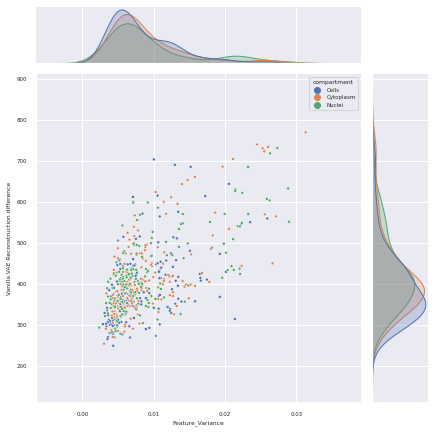

In [55]:
sns.jointplot(data = difference_vanilla, y = 'Vanilla VAE Reconstruction difference', x = 'Feature_Variance', hue = 'compartment', marker = '.')
plt.savefig('vanilla_jointplot_compartment.jpg', dpi=400)

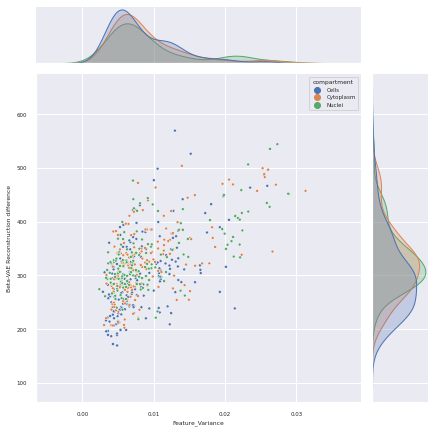

In [56]:
sns.jointplot(data = difference_beta, y = 'Beta-VAE Reconstruction difference', x = 'Feature_Variance', hue = 'compartment', marker = '.')
plt.savefig('beta_jointplot_compartment.jpg', dpi=400)

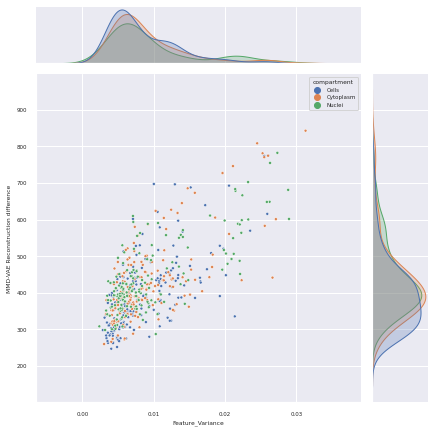

In [57]:
sns.jointplot(data = difference_mmd, y = 'MMD-VAE Reconstruction difference', x = 'Feature_Variance', hue = 'compartment', marker = '.')
plt.savefig('mmd_jointplot_compartment.jpg', dpi=400)

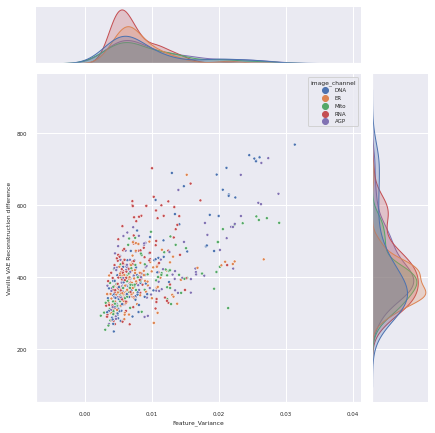

In [58]:
sns.jointplot(data = difference_vanilla, y = 'Vanilla VAE Reconstruction difference', x = 'Feature_Variance', hue = 'image_channel', marker = '.')
plt.savefig('vanilla_jointplot_imagechannel.jpg', dpi=400)

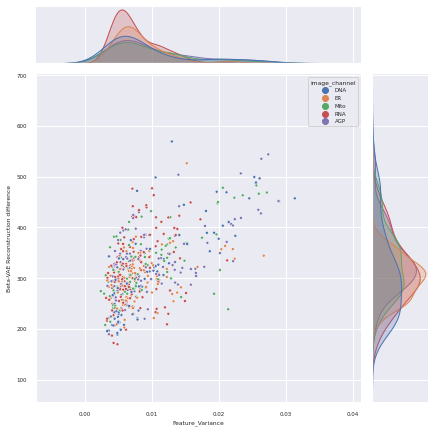

In [59]:
sns.jointplot(data = difference_beta, y = 'Beta-VAE Reconstruction difference', x = 'Feature_Variance', hue = 'image_channel', marker = '.')
plt.savefig('beta_jointplot_imagechannel.jpg', dpi=400)

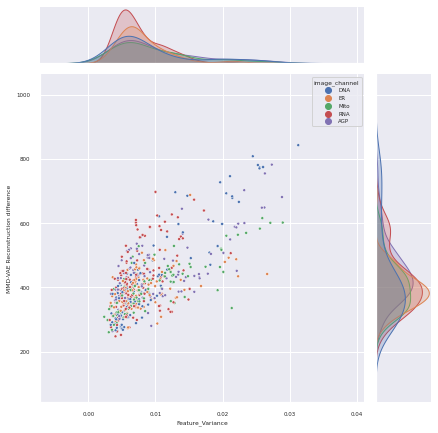

In [60]:
sns.jointplot(data = difference_mmd, y = 'MMD-VAE Reconstruction difference', x = 'Feature_Variance', hue = 'image_channel', marker = '.')
plt.savefig('mmd_jointplot_imagechannel.jpg', dpi=400)